# Chapter12-Counting,sorting,and distributed coordination

This chapter covers several useful patterns for distribution coordination: combining, counting, diffraction, sampling

Question: How to construct the basic structure underlying these patterns?


## Shared counting

We have a pool which is a collection of items that provides `put()` and `get()` methods to insert and remove items.

We can implement a pool by making both put() and get() synchronized. The lock will cause a sequential bottleneck, forcing all method calls to synchronize, and memory contention.

Alternatively, we can make the pool become a cyclic array, where each array entry contains either an item or null. We route threads through two counters. Threads calling put() increment one counter to choose an array index. Similarly, threads calling get() increment another counter.

How can we build highly parallel counters through data structures that coordinate the distribution of counter indices?

### Software combining

The possible values for the combining status, and their associated meanings are:
- IDLE: This node is not in use.
- FIRST: One active thread has visited this node, and will return to check whether another passive thread has left a value with which to combine.
- SECOND: A second thread has visited this node and stored a value in the node’s value field to be combined with the active thread’s value, but the combined operation is not yet complete.
- RESULT: Both threads’ operations have been combined and completed, and the second thread’s result has been stored in the node’s result field.
- ROOT: This value is a special case to indicate that the node is the root, and must be treated specially.


```algorithm
monitor Node {
    enum CStatus {IDLE, FIRST, SECOND, RESULT, ROOT}
    var locked: boolean
    var firstValue, secondValue: integer
    var result: integer
    var cStatus: CStatus
    var parent: Node
    
    {CI: firstValue ≥ 0 ∧ secondeValue ≥ 0 ∧ result ≥ 0}
    initialization()
        parent, cStatus, locked, firstValue, secondValue, result := null, ROOT, false, 0, 0, 0
    
    initialization(myParent: Node)
        parent, cStatus, locked, firstValue, secondValue, result := myParent, IDLE, false, 0, 0, 0
      
    procedure precombine() -> (a: bool)
        {cStatus ≠ SECOND ∧ cStatus ≠ RESULT}
        while locked = true do wait()
        if cStatus = IDLE then cStatus := FIRST; a := true
        if cStatus = FIRST then locked, cStatus := true, SECOND; a := false
        if cStatus = ROOT then cStatus := FIRST; a := false
        {cStatus = FIRST ∨ cStstus = SECOND}
    
    procedure combine(combined: integer) -> (a: integer)
        {cStatus = FIRST ∨ cStatus = SECOND}
        while locked = true do wait
        locked, firstValue := true, combined
        if cStatus = FIRST then a := firstValue
        if cStatus = SECOND then a := firstValue + secondValue
        
    procedure op(combined: integer) -> (a : integer)
        {cStatus = ROOT ∨ cStatus = SECOND}
        if cStatus = ROOT then 
            prior, result := result, result + combined
            a := prior
        if cStatus = SECOND then 
            secondValue, locked := combined, false
            signal()
            while cStatus ≠ RESULT do wait()
            locked := false
            signal()
            cStatus := IDLE
            a := result
              
    procedure distribute(prior: integer)
        {cStatus = FIRST ∨ cStatus = SECOND}
        if cStatus = FIRST then cStatus, locked := IDLE, false
        if cStatus = SECOND then result, cStatus := prior + firstValue, RESULT
        signal()
            
}

```

```
class CombiningTree {
    
    {CI: leaf.length×2 = nodes.length+1 ∧  
            (∀ i ∈ 0..leaf.length-1 • leaf(i) = nodes(nodes.length-i-1)) }
    initialization(width: integer) {
        var nodes : array 0..2×width-1 of Node
        var leaf : array 0..width of Node
        
        nodes(0) := Node()
        i := 0
        while i < nodes.length do
            nodes(i), i := Node(nodes((i-1)/2)), i+1
            
        i := 1
        while i < leaf.length do
            leaf(i), i := nodes(nodes.length-i-1), i+1
    }
    
    
    method getAndIncrement(）-> (prior: integer)
        var stack : array 0..top of Node
        top: integer = 0
        myLeaf := leaf(ThreadID % leaf.length)
        node := myLeaf
        //precombining phase
        while node.precombine() = true do node := node.parent //find the root or locked node
        stop := node
        //combining phase
        combined: integer =1
        node := myLeaf
        while node ≠ stop do 
            combined, stack(top), node, top := 
                    node.combine(combined), node, node.parent, top+1
        //operation phase
        prior := stop.op(combined)
        //distribute phase
        while stack.length ≠ 0 do
            node, top :=stack(top), top-1
            node.distribute(prior)

}

```

The concurrent traversal of a width 8 combining tree by five threads.

<img src="images/combining-tree-execution.png" width=700 />

In [1]:
%%writefile Node.java
public class Node {
    enum CStatus{IDLE, FIRST, SECOND, RESULT, ROOT};
    boolean locked;
    CStatus cStatus;
    int firstValue, secondValue;
    int result;
    Node parent;
    public Node() {
        cStatus = CStatus.ROOT;
        locked = false;
    }
    public Node(Node myParent) {
        parent = myParent;
        cStatus = CStatus.IDLE;
        locked = false;
    }
    
    synchronized boolean precombine() throws InterruptedException{
        while (locked) wait();
        switch (cStatus) {
            case IDLE:
                cStatus = CStatus.FIRST;
                return true;
            case FIRST:
                locked = true;
                cStatus = CStatus.SECOND;
                return false;
            case ROOT:
                return false;
            default:
                throw new InterruptedException("unexpected Node state" + cStatus);
        }
    }
    
    synchronized int combine(int combined) throws InterruptedException{
        while (locked) wait();
        locked = true;
        firstValue = combined;
        switch (cStatus) {
            case FIRST:
                return firstValue;
            case SECOND:
                return firstValue + secondValue;
            default:
                throw new InterruptedException("unexpected Node state " + cStatus);
        }
    }
    
    synchronized int op(int combined)  throws InterruptedException{
        switch (cStatus) {
            case ROOT:
                int prior = result;
                result += combined;
                return prior;
            case SECOND:
                secondValue = combined;
                locked = false;
                notifyAll(); // wake up waiting threads
                while (cStatus != CStatus.RESULT) wait();
                locked = false;
                notifyAll();
                cStatus = CStatus.IDLE;
                return result;
            default:
                throw new InterruptedException("unexpected Node state");
        }
    }
    
    synchronized void distribute(int prior) throws InterruptedException{
        switch (cStatus) {
            case FIRST:
                cStatus = CStatus.IDLE;
                locked = false;
                break;
            case SECOND:
                result = prior + firstValue;
                cStatus = CStatus.RESULT;
                break;
            default:
                throw new InterruptedException("unexpected Node state");
        }
        notifyAll();
    }
}

Writing Node.java


In [1]:
%%writefile CombiningTree.java
import java.util.*;


public class CombiningTree {
    Node[] leaf;
    Node[] nodes;
    
    public CombiningTree(int width) {
        nodes = new Node[2*width -1];
        nodes[0] = new Node();
        for(int i=1; i<nodes.length; i++) {
            nodes[i] = new Node(nodes[(i-1)/2]);
        }
        leaf = new Node[width];
        for(int i=0; i<leaf.length; i++) {
            leaf[i] = nodes[nodes.length-i-1];
        }  
    }
    
    public int getAndIncrement() {
        Stack<Node> stack = new Stack<Node>();
        int ThreadID = (int) Thread.currentThread().getId();
        Node myLeaf = leaf[ThreadID % leaf.length];
        Node node = myLeaf;
        // precombining phase
        try{
            while (node.precombine()) {
                node = node.parent;
            }
        }catch(Exception e) {}
        Node stop = node;
        // combining phase
        int combined = 1;
        for (node = myLeaf; node != stop; node = node.parent) {
            try{combined = node.combine(combined);} catch (Exception e){}
            stack.push(node);
        }
        try{
            // operation phase
            int prior = stop.op(combined);
            // distribution phase
            while (!stack.empty()) {
                node = stack.pop();
                node.distribute(prior);
            }
            return prior;
        }catch(Exception e){}
        return -1;
        
    }
    
    public int get() {
        return nodes[0].result;
    }
}

Overwriting CombiningTree.java


In [2]:
%%writefile TestCombiningTree.java
import java.util.*;

class TestCombiningTree {
    static CombiningTree tree;
    static int TH = 12, NUM = 100;
    static int width;
    // tree: combining tree where threads do increment ops
    // TH: number of threads
    // NUM: number of increment operations each thread performs

    static Thread thread(int id) {
        return new Thread(() -> {
            
            long start = System.currentTimeMillis();
            for (int i=0; i<NUM; i++) {
               tree.getAndIncrement();
            }
            long stop = System.currentTimeMillis();
            log(id()+": done in "+(stop-start)+"ms");
        });
    }

    // Setup the combining tree for threads.
    static void setupTree() {
        width = (int) Math.ceil(TH/2);
        tree = new CombiningTree(width);
    }


    // Start threads doing increments using tree.
    static Thread[] startOps() {
        Thread[] t = new Thread[TH];
        for (int i=0; i<TH; i++)
          t[i] = thread(i);
        for (int i=0; i<TH; i++)
          t[i].start();
        return t;
    }

    // Wait until all threads done with increments.
    static void awaitOps(Thread[] t) {
        try {
        for (int i=0; i<TH; i++)
          t[i].join();
        } catch (InterruptedException e) {}
    }

    public static void main(String[] args) {
        setupTree();
        log( width +"-leaves Combining tree.");
        log("Starting "+ TH +" threads doing increments ...");
        long start = System.currentTimeMillis();
        Thread[] t = startOps();
        awaitOps(t);
        long stop = System.currentTimeMillis();
        log("Total: "+tree.get());
        log("Total time: "+(stop-start)+"ms");
    }

    static void log(String x) {
        System.out.println(x);
    }

    static long id() {
        return Thread.currentThread().getId();
    }
}

Overwriting TestCombiningTree.java


In [14]:
!javac TestCombiningTree.java

In [15]:
!java -ea TestCombiningTree

6-leaves Combining tree.
Starting 12 threads doing increments ...
17: done in 5ms
19: done in 10ms
18: done in 9ms
14: done in 10ms
25: done in 10ms
15: done in 11ms
23: done in 5ms
20: done in 9ms
16: done in 7ms
24: done in 8ms
22: done in 6ms
21: done in 11ms
Total: 1200
Total time: 19ms


Assume we have p threads, the depth of Combinning Tree is at least $\log p$. So each increment takes $O(\log p)$.

- Next problem is how to distribute the threads among the counters so that there are no duplications or omissions if we replace the combining tree's single counter with mutiple counters

## Counting networks

### Balancer

- A balancer has two states: up and down. If the state is up, the next token exits on the top wire; otherwise it exits on the bottom wire.

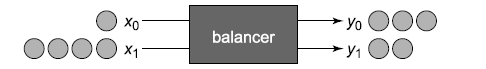


- A balancing network is ***quiescent*** if every token that arrived on an input wire has emerged on an output wire: $$\sum x_i = \sum y_i $$


- step property: In general, if $$ n = \sum x_i $$ then, when the network is quiescent, $$ y_i = \lceil (n-i)/w\rceil$$


- A balancing network that satisfies the *step property* is called a **counting network**


### Merger


- a Merger[k] network merge the even subsequence x0, x2, ..., xk-1 of x with the odd subsequence x1',x2',..x'k-1 of x'


<img src="images/Merger.png" width=500/>


### Bitonic


- Bitonic[2k] network passes the output from two Bitonic[k] networks into a Merger[2k]

### Bitonic counting network



<img src="images/counting_network.png" width=700 />

```
monitor Balancer {
    toggle : boolean = true
    
    procedure traverse() -> (a: integer)
        if toggle = true then
            a := 0
        else
            a := 1
        toggle:=!toggle
}


class Merger {

    var half : Array 0..h of Merger
    var layer : Array 0..b of Balancer
    var width : integer
    
    {CI: b = width/2 }
    initialization (myWidth: integer)
        width := myWidth
        b := width/2
        i := 0
        while i < width/2 do layer(i), i := Balancer(), i+1
        if width>2 then
            h := 2
            half(0), half(1) := Merger(width/2), Merger(width/2)
    
    { 0 <= input < width }
    method traverse(input : integer) -> (a: integer)
        output := 0
        if width ≤ 2 then 
            a := layer(0).traverser()
        if input < width/2 then 
            output := half(input%2).traverse(input/2)
        else 
            output := half(1-input%2).traverse(input/2)
        a := (2*output) + layer(output).traverse()
}


class Bitonic {
    
    half : Array 0..h of Bitonic
    merger : Merger
    width : integer
    
    initialization (myWidth : integer)
        width := myWidth
        merger := Merger(width)
        if width > 2 then
            h := 2
            half(0), half(1) := Bitonic(width/2), Bitonic(width/2)
    
    { 0 <= input < width ∧ 0 ≤ subnet ≤ 1 }
    method traverse(input : integer) -> (a : integer)
        output:=0
        subnet:=input/(width/2)
        if width>2 then
            output:=half(subnet).traverse(input/2)
            
        if input ≥ width/2 then 
            a := merger.traverse(width/2 + output)
        else
            a := merger.travese(output)

}

```

In [8]:
%%writefile Balancer.java
public class Balancer {
    boolean toggle = true;
    public synchronized int traverse() {
        try {
            if (toggle) {
            return 0;
            } else {
            return 1;
            }
        } finally {
            toggle = !toggle;
        }
    }
}

Overwriting Balancer.java


In [7]:
%%writefile Merger.java
public class Merger {
    Merger[] half; // two half-width merger networks
    Balancer[] layer; //final layer
    final int width;
    public Merger(int myWidth) {
        width = myWidth;
        layer = new Balancer[width / 2];
        for (int i = 0; i < width / 2; i++) {
            layer[i] = new Balancer();
        }
        if (width > 2) {
            half = new Merger[]{new Merger(width/2), new Merger(width/2)};
        }
    }
    public int traverse(int input) {
        int output = 0;
        
        if (width<=2) return layer[0].traverse();
        
        if (input < width / 2) {
            output = half[input % 2].traverse(input / 2);
        } else {
            output = half[1 - (input % 2)].traverse(input / 2);
        }
        return (2 * output) + layer[output].traverse();
    }
}

Writing Merger.java


In [9]:
%%writefile Bitonic.java
public class Bitonic {
    Bitonic[] half; // two half-width bitonic networks
    Merger merger; // final merger layer
    final int width; // network width
    public Bitonic(int myWidth) {
        width = myWidth;
        merger = new Merger(width);
        if (width > 2) {
            half = new Bitonic[]{new Bitonic(width/2), new Bitonic(width/2)};
        }
    }
    public int traverse(int input) {
        int output = 0;
        int subnet = input / (width / 2);
        if (width > 2) {
            output = half[subnet].traverse(input/2);
        }
        return merger.traverse((input>=width/2 ? (width/2) :0) + output);
    }
}

Writing Bitonic.java


In [10]:
%%writefile Test.java

import java.util.*;
import java.util.concurrent.atomic.AtomicInteger;

public class Test{
    static int width = 4;
    static int[] counters = new int[width];
    static Bitonic bitonic = new Bitonic(width);
    static int tokenCount = 1000;
    static int[] tokens = new int[tokenCount];
    
    
    static Thread thread(int i) {
        return new Thread(() -> {                          
            counters[bitonic.traverse(tokens[i])]+=1;
        });
    }
    
    public static void main(String[] args) {
        
        Random rand = new Random();
        for(int i=0; i<tokenCount; i++){
            tokens[i]=rand.nextInt(width);
        }
        
            
        Thread[] t = new Thread[tokenCount];
        long start = System.currentTimeMillis();
        for (int i=0; i<tokenCount; i++)
          t[i] = thread(i);
        for (int i=0; i<tokenCount; i++)
          t[i].start();
        try {
        for (int i=0; i<tokenCount; i++)
          t[i].join();
        } catch (InterruptedException e) {}
        long stop = System.currentTimeMillis();
               
        for (var i = 0; i < width; ++i)
        {
            System.out.println("Output: " + i +", Count: "+counters[i]);
        }
        
        System.out.println("Total time to traverse the network: " + (stop-start) +"ms");
    }
}

Overwriting Test.java


In [11]:
!javac Test.java

In [12]:
!java -ea Test

Output: 0, Count: 250
Output: 1, Count: 250
Output: 2, Count: 250
Output: 3, Count: 250
Total time to traverse the network: 107ms


Bitonic[2k] is a counting network with depth $O(\log^2 (2k))$. The complexty is the same.

$$ \text{Depth_Bitonic[2k]} = \left\{ \begin{array}{l}
1 & k=1 \\ 
\text{Depth_Merger[2k]} + 2 \times \text{ Depth_Bitonic[k]}  & k>1
\end{array}\right.
$$

$$
\text{Depth_Merger[2k]} = \left\{ \begin{array}{l}
1 & k=1 \\ 
1 + 2 \times \text{Depth_Merger[k]}  & k>1
\end{array}\right.
$$




## Conclusion:

- The idea behind the combining tree: if two threads read a node at approximately the same time, they combine their increments by adding them together. One thread, the active thread, propagates their combined increments up the tree, while the other, the passive thread, waits for the active thread to complete their combined work.


- The idea behind the counting network: build a balancer network that satisfies the step property to count the number of tokens that have traversed the network.

## Reference: 
1. Herlihy, M., Shavit, N., Luchangco, V., & Spear, M. (2020). The art of multiprocessor programming. Newnes.
2. Subhajit Sahu. (2020, November 13). javaf/combining-tree. Github. https://github.com/javaf/combining-tree/blob/master/Main.java